In [1]:
#Imports 
#Copyright Nader S. Opeyany
import json 
import csv 
import pandas as pd 
import sklearn as sk
import numpy as np
import io
from collections.abc import Sequence
import shutil
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn.feature_extraction.text as sk_text
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn import preprocessing as le
from sklearn.metrics import confusion_matrix, classification_report


In [15]:
#Helpful Gems, lab 9

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
def zeroToOne(string):
    if(string =='normal'):
        return 0
    else:
        return 1
    
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


In [3]:
df = pd.read_csv('network_intrusion_data.csv',na_values=['NA','?'])
df.columns = [ 
    'duration', 
    'protocol_type', 
    'service', 
    'flag', 
    'src_bytes', 
    'dst_bytes', 
    'land', 
    'wrong_fragment', 
    'urgent', 
    'hot', 
    'num_failed_logins', 
    'logged_in', 
    'num_compromised', 
    'root_shell', 
    'su_attempted', 
    'num_root', 
    'num_file_creations', 
    'num_shells', 
    'num_access_files', 
    'num_outbound_cmds', 
    'is_host_login', 
    'is_guest_login', 
    'count', 
    'srv_count', 
    'serror_rate', 
    'srv_serror_rate', 
    'rerror_rate', 
    'srv_rerror_rate', 
    'same_srv_rate', 
    'diff_srv_rate', 
    'srv_diff_host_rate', 
    'dst_host_count', 
    'dst_host_srv_count', 
    'dst_host_same_srv_rate', 
    'dst_host_diff_srv_rate', 
    'dst_host_same_src_port_rate', 
    'dst_host_srv_diff_host_rate', 
    'dst_host_serror_rate', 
    'dst_host_srv_serror_rate', 
    'dst_host_rerror_rate', 
    'dst_host_srv_rerror_rate', 
    'outcome' 
] 
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [4]:
#removes duplicates
df = df.drop_duplicates()
#checks data types, protocol_type , service , flag , outcome are all objects need to be encoded
df.dtypes
#df.info


duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [5]:
infoTypes = {}
#given info on which needs to be handled differently from project 2 
infoTypes["duration"] = "continuous"
infoTypes['protocol_type'] ='discrete'
infoTypes['service'] = 'discrete'
infoTypes['flag'] = 'discrete'
infoTypes['src_bytes'] = 'continuos'
infoTypes['dst_bytes'] = 'continuous'
infoTypes['land'] = 'discrete'
infoTypes['wrong_fragment'] = 'continuous'
infoTypes['urgent'] = 'continuous'
infoTypes['hot'] = 'continuous'
infoTypes['num_failed_logins'] = 'continuous'
infoTypes['logged_in'] = 'discrete'
infoTypes['num_compromised'] = 'continuous'
infoTypes['root_shell'] = 'continuous'
infoTypes['su_attempted'] = 'continuous'
infoTypes['num_root'] = 'continuous'
infoTypes['num_file_creations'] = 'continuous'
infoTypes['num_shells'] = 'continuous'
infoTypes['num_access_files'] = 'continuous'
infoTypes['num_outbound_cmds'] = 'continuous'
infoTypes['is_host_login'] = 'discrete'
infoTypes['is_guest_login'] = 'discrete'
infoTypes['count'] = 'continuous'
infoTypes['srv_count'] = 'continuous'
infoTypes['serror_rate'] = 'continuous'
infoTypes['srv_serror_rate'] = 'continuous'
infoTypes['rerror_rate'] = 'continuous'
infoTypes['srv_rerror_rate'] = 'continuous'
infoTypes['same_srv_rate'] = 'continuous'
infoTypes['diff_srv_rate'] = 'continuous'
infoTypes['srv_diff_host_rate'] = 'continuous'
infoTypes['dst_host_count'] = 'continuous'
infoTypes['dst_host_srv_count'] = 'continuous'
infoTypes['dst_host_same_srv_rate'] = 'continuous'
infoTypes['dst_host_diff_srv_rate'] = 'continuous'
infoTypes['dst_host_same_src_port_rate'] = 'continuous'
infoTypes['dst_host_srv_diff_host_rate'] = 'continuous'
infoTypes['dst_host_serror_rate'] = 'continuous'
infoTypes['dst_host_srv_serror_rate'] = 'continuous'
infoTypes['dst_host_rerror_rate'] = 'continuous'
infoTypes['dst_host_srv_rerror_rate'] = 'continuous'
infoTypes['outcome'] = 'discrete'

print('intialized')
print(infoTypes)

intialized
{'duration': 'continuous', 'protocol_type': 'discrete', 'service': 'discrete', 'flag': 'discrete', 'src_bytes': 'continuos', 'dst_bytes': 'continuous', 'land': 'discrete', 'wrong_fragment': 'continuous', 'urgent': 'continuous', 'hot': 'continuous', 'num_failed_logins': 'continuous', 'logged_in': 'discrete', 'num_compromised': 'continuous', 'root_shell': 'continuous', 'su_attempted': 'continuous', 'num_root': 'continuous', 'num_file_creations': 'continuous', 'num_shells': 'continuous', 'num_access_files': 'continuous', 'num_outbound_cmds': 'continuous', 'is_host_login': 'discrete', 'is_guest_login': 'discrete', 'count': 'continuous', 'srv_count': 'continuous', 'serror_rate': 'continuous', 'srv_serror_rate': 'continuous', 'rerror_rate': 'continuous', 'srv_rerror_rate': 'continuous', 'same_srv_rate': 'continuous', 'diff_srv_rate': 'continuous', 'srv_diff_host_rate': 'continuous', 'dst_host_count': 'continuous', 'dst_host_srv_count': 'continuous', 'dst_host_same_srv_rate': 'cont

In [6]:
i = 0
#Normalize data with given funtion for int/float columns
for (index,column) in df.iteritems():
    if (infoTypes[index] == 'continuos'):
        encode_numeric_zscore(df, index)
    
df.shape

<ipython-input-2-28bb82a4a207>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


(145585, 42)

In [19]:
#Choosing what makes a bad connection and what doesnt
attach = ['outcome','back','buffer_overflow','ftp_write','guess_passwd','imap','ipsweep','land','loadmodule','multihop','neptune'
,'nmap','normal','perl','phf','pod','portsweep','rootkit','satan','smurf','spy','teardrop','warezclient','warezmaster' ] #list of attacks
#na drop
df = df.dropna()
df = df.replace({'normal.':'normal'})
df_good = df[df['outcome'] == 'normal']
df_bad = df.drop(df_good.index)
#for (index,column) in pd:
print(df_good.shape)
print(df_bad.shape)

(87831, 42)
(57754, 42)


In [20]:
#map
y = df['outcome'].map(zeroToOne)
df_ForX = df.drop(['outcome','protocol_type','service','flag'],axis = 1)
x = df_ForX.copy()
#x and y
print(df.shape)
print(x)

(145585, 42)
        duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0              0  -0.004261        486     0               0       0    0   
1              0  -0.004263       1337     0               0       0    0   
2              0  -0.004272       1337     0               0       0    0   
3              0  -0.004273       2032     0               0       0    0   
4              0  -0.004273       2032     0               0       0    0   
...          ...        ...        ...   ...             ...     ...  ...   
494015         0  -0.004222       1881     0               0       0    0   
494016         0  -0.004237       2286     0               0       0    0   
494017         0  -0.004281       1200     0               0       0    0   
494018         0  -0.004232       1200     0               0       0    0   
494019         0  -0.004272       1234     0               0       0    0   

        num_failed_logins  logged_in  num_compromised  ...  ds

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =.25)
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=100, verbose=2, mode='auto')  
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=30)  



Epoch 1/30
3413/3413 - 3s - loss: 1236170.6250 - val_loss: 5842419.5000
Epoch 2/30
3413/3413 - 4s - loss: 399255.6250 - val_loss: 3733.9165
Epoch 3/30
3413/3413 - 3s - loss: 206752.4688 - val_loss: 8239927.0000
Epoch 4/30
3413/3413 - 3s - loss: 868491.9375 - val_loss: 49728.5664
Epoch 5/30
3413/3413 - 3s - loss: 1039574.3125 - val_loss: 707656.7500
Epoch 6/30
3413/3413 - 3s - loss: 500034.4375 - val_loss: 665676.4375
Epoch 7/30
3413/3413 - 3s - loss: 191748.6562 - val_loss: 36094.4180
Epoch 8/30
3413/3413 - 3s - loss: 715542.5625 - val_loss: 93383.1875
Epoch 9/30
3413/3413 - 3s - loss: 39552.2852 - val_loss: 688896.5625
Epoch 10/30
3413/3413 - 3s - loss: 556003.6875 - val_loss: 35808.7891
Epoch 11/30
3413/3413 - 3s - loss: 508477.7188 - val_loss: 1561324.3750
Epoch 12/30
3413/3413 - 3s - loss: 347337.8438 - val_loss: 153.0622
Epoch 13/30
3413/3413 - 3s - loss: 377661.3438 - val_loss: 1208.9269
Epoch 14/30
3413/3413 - 4s - loss: 193372.6250 - val_loss: 326682.6250
Epoch 15/30
3413/3413 

In [11]:
y_HotEncoding = tf.keras.utils.to_categorical(y,2)
print(x_test.shape)

(36397, 38)


Accuracy: 0.4272604885017996
Averaged F1: 0.2938927670655107
              precision    recall  f1-score   support

           0       0.89      0.06      0.11     21920
           1       0.41      0.99      0.58     14477

    accuracy                           0.43     36397
   macro avg       0.65      0.52      0.34     36397
weighted avg       0.70      0.43      0.29     36397

[[ 1233 20687]
 [  159 14318]]
              precision    recall  f1-score   support

           0       0.89      0.06      0.11     21920
           1       0.41      0.99      0.58     14477

    accuracy                           0.43     36397
   macro avg       0.65      0.52      0.34     36397
weighted avg       0.70      0.43      0.29     36397



<Figure size 432x288 with 0 Axes>

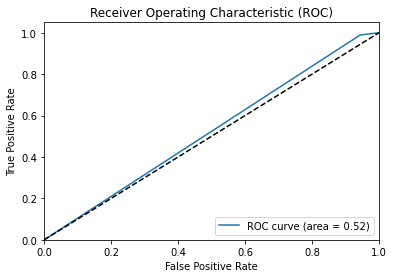

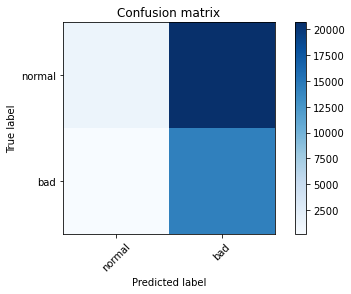

In [16]:
#output model
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
#y_true can be a list, just x_test needs to be matrix/array
y_true = y_test.astype(int).tolist()


score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

cm = confusion_matrix(y_true,pred)
print(cm)
plot_lables = ['normal','bad']
plt.figure()

print(classification_report(y_true, pred))
plot_roc(pred,y_true)

plot_confusion_matrix(cm,plot_lables)
plt.show()